In [30]:
# Reference: Pythonによる時系列分析の基礎 - Logics of Blue - https://logics-of-blue.com/python-time-series-analysis/

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io
import requests
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

In [2]:
# URL reference: A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
url = 'https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv'
s = requests.get(url).content
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
dataNormal = pd.read_csv(io.StringIO(s.decode('utf-8')))
data = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col='Month', date_parser=dateparse, dtype='float' )

In [3]:
data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [4]:
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

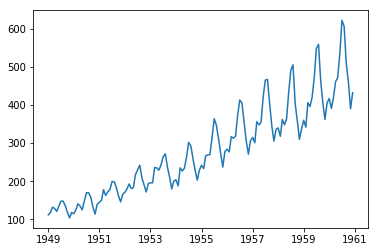

In [5]:
plt.plot(ts)

In [6]:
diff = ts - ts.shift()
diff.head()

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: #Passengers, dtype: float64

In [8]:
logDiff = np.log(ts) - np.log(ts.shift())
logDiff = logDiff.dropna()

<Container object of 41 artists>

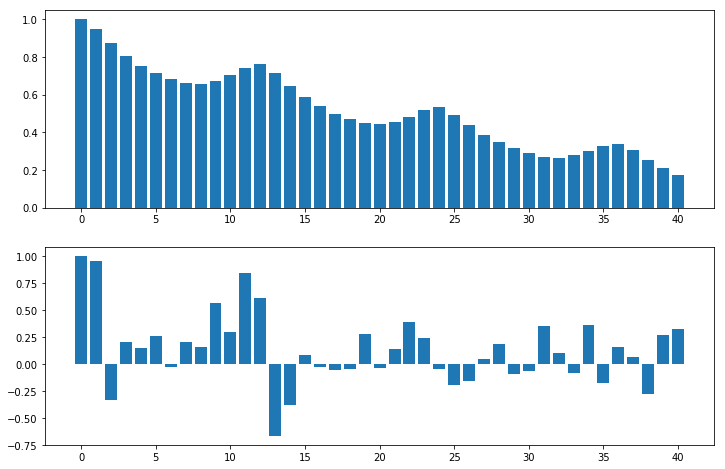

In [18]:
ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.bar(np.arange(len(ts_acf)), ts_acf)
ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
plt.subplot(212)
plt.bar(np.arange(len(ts_pacf)), ts_pacf)

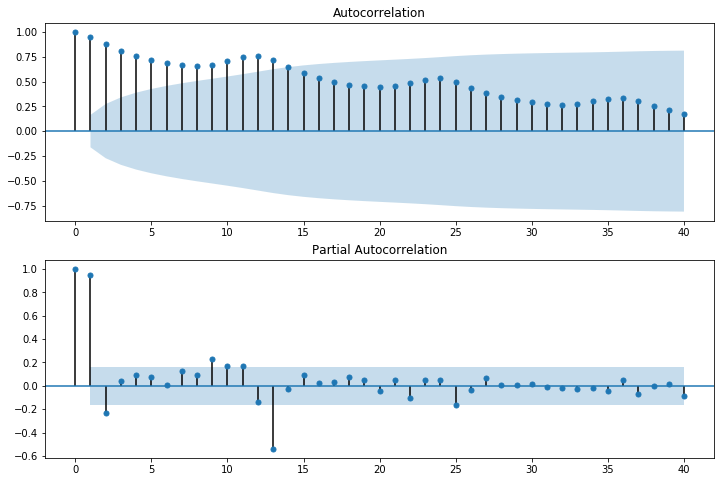

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

In [31]:
diff = ts - ts.shift()
diff = diff.dropna()

# trend = {'c','nc'}
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
resDiff

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175665
 3  1395.021214  1379.614000  1351.138656
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

In [37]:
ARIMA_3_1_2 = ARIMA(ts, order=(3,1,2)).fit()
ARIMA_3_1_2.params

const                  2.673500
ar.L1.D.#Passengers    0.261992
ar.L2.D.#Passengers    0.367828
ar.L3.D.#Passengers   -0.363472
ma.L1.D.#Passengers   -0.075043
ma.L2.D.#Passengers   -0.924840
dtype: float64

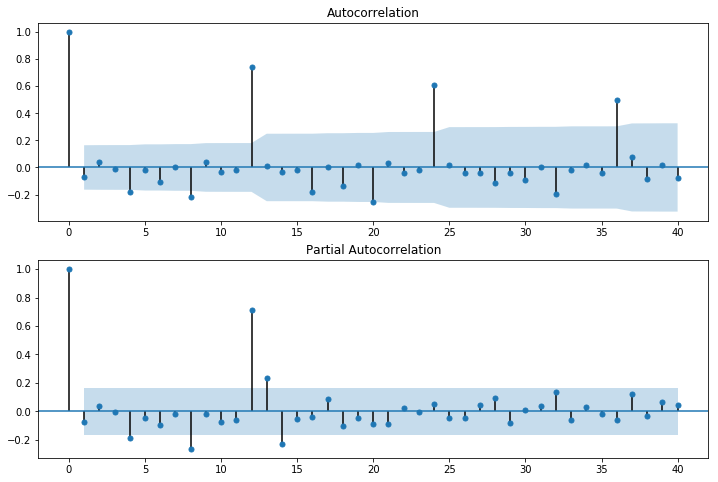

In [40]:
resid = ARIMA_3_1_2.resid
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [41]:
SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
print(SARIMA_3_1_2_111.summary())

/usr/local/pyenv/versions/3.5.3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.989
Date:                            Sun, 24 Dec 2017   AIC                           1021.979
Time:                                    14:57:24   BIC                           1045.738
Sample:                                01-01-1949   HQIC                          1031.633
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5354      1.663      0.322      0.747      -2.723       3.794
ar.L2          0.2838      0.962   

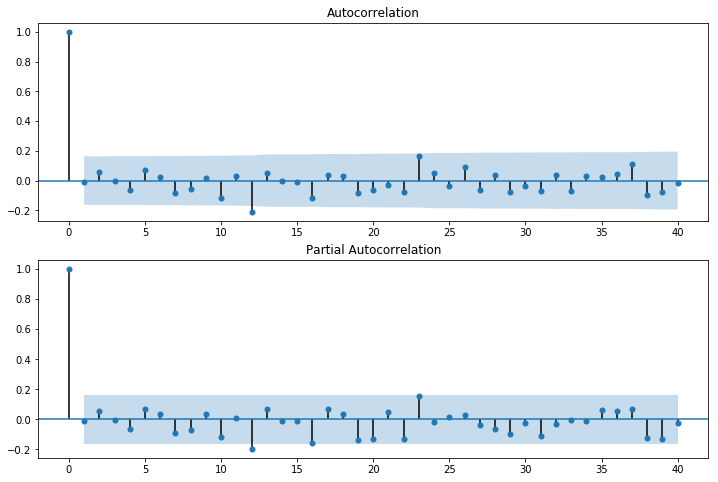

In [43]:
residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

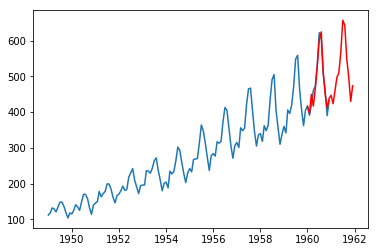

In [47]:
pred = SARIMA_3_1_2_111.predict('1960-01-01', '1961-12-01')
plt.plot(ts)
plt.plot(pred, 'r')

In [52]:
max_p = max_q = 3
max_d = max_sp = max_sq = max_sd = 1

pattern = max_p * (max_q + 1) * (max_d + 1) * (max_sp + 1) * (max_sq + 1) * (max_sd + 1)
modelSelection = pd.DataFrame(index=range(pattern), columns=['model','aic'])
pattern

192

In [53]:
num = 0
 
for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.ix[num]["aic"] = sarima.aic
                        num = num + 1

/usr/local/pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/usr/local/pyenv/versions/3.5.3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/pyenv/versions/3.5.3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/pyenv/versions/3.5.3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

In [54]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]


,model,aic
187,"order=(3,1,3), season=(0,1,1)",898.105


In [55]:
bestSARIMA = sm.tsa.SARIMAX(ts, order=(3,1,3), seasonal_order=(0,1,1,12), enforce_stationarity = False, enforce_invertibility = False).fit()
print(bestSARIMA.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -441.052
Date:                            Sun, 24 Dec 2017   AIC                            898.105
Time:                                    15:08:40   BIC                            921.863
Sample:                                01-01-1949   HQIC                           907.759
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2231      0.097     -2.302      0.021      -0.413      -0.033
ar.L2         -0.1642      0.108   

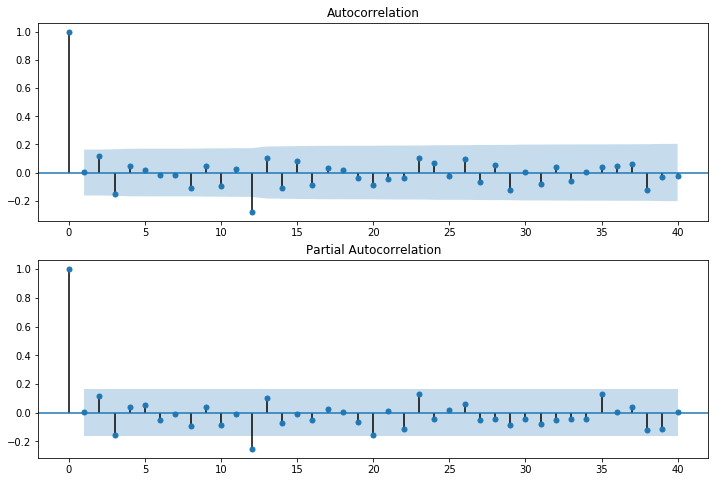

In [56]:
residSARIMA = bestSARIMA.resid
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

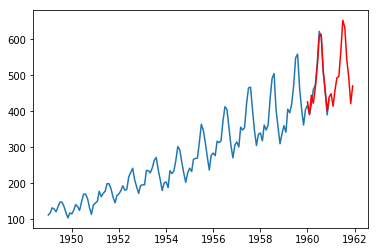

In [59]:
bestPred = bestSARIMA.predict('1960-01-01', '1961-12-01')
plt.plot(ts)
plt.plot(bestPred,'r')